In [1]:
# imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import shap

/home/hfridl/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# creat a DataFrame for the data
df = pd.read_csv('weatherAUS.csv')

In [3]:
# check number of null values in each column
df.isna().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

In [4]:
# delete all rows (samples) with NaN values in the 'RainTomorrow' and 'RainToday' column
df = df.dropna(subset=['RainTomorrow'])
df = df.dropna(subset=['RainToday'])

In [5]:
# information about the dataset, checking features Dtype
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140787 entries, 0 to 145458
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           140787 non-null  object 
 1   Location       140787 non-null  object 
 2   MinTemp        140319 non-null  float64
 3   MaxTemp        140480 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81093 non-null   float64
 6   Sunshine       73982 non-null   float64
 7   WindGustDir    131624 non-null  object 
 8   WindGustSpeed  131682 non-null  float64
 9   WindDir9am     131127 non-null  object 
 10  WindDir3pm     137117 non-null  object 
 11  WindSpeed9am   139732 non-null  float64
 12  WindSpeed3pm   138256 non-null  float64
 13  Humidity9am    139270 non-null  float64
 14  Humidity3pm    137286 non-null  float64
 15  Pressure9am    127044 non-null  float64
 16  Pressure3pm    127018 non-null  float64
 17  Cloud9am       88162 non-null

In [6]:
# sort the categorical and numerical feature headers into two lists
numerical_features = df.select_dtypes(include=['float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
categorical_features.remove('RainTomorrow') #remove output feature
print(numerical_features)
print(categorical_features)

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']


In [7]:
# handle NaN/Null values for numerical features by replacing NaN/Null by the mean of all values for that feature
for feature in numerical_features:
    df[feature] = df[feature].fillna(df[feature].mean())

In [8]:
# handle NaN/Null values for categorical features by replacing NaN/Null by the most common lable for that feature
for feature in categorical_features:
    df[feature] = df[feature].fillna(df[feature].mode()[0])

In [9]:
# creat input(X) and output(y) dataframe
X = df.drop(columns='RainTomorrow')
y = df['RainTomorrow']
y = y == 'Yes'
y.loc[y == True] = 1 
y.loc[y == False] = 0
y = y.astype('int')

In [10]:
# split dataset into train-, validation- and test-set
X_train, X_testval, y_train, y_testval = train_test_split(X, y, train_size=0.80)
X_test, X_val, y_test, y_val = train_test_split(X_testval, y_testval, train_size=0.75, test_size=0.25)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(112629, 22)
(7040, 22)
(21118, 22)


In [11]:
# start setup for pre-processing the data
numeric_transformer = 'passthrough'             # leave untransformed
categorical_transformer = Pipeline(steps=[      # setup pipeline for transforming categorical features
    ('categorical_transformer', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])
# set up column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numeric_transformer, numerical_features),
        ('categorical', categorical_transformer, categorical_features)
    ])

In [14]:
# Create a pipeline between preprocessor and ML models
rf_model = Pipeline(steps=[('transformed_data', preprocessor),
                      ('classifier', RandomForestClassifier())])
svm_model = Pipeline(steps=[('transformed_data', preprocessor),
                      ('classifier', SVC())])

In [15]:
# fit the models on the full-featured dataset
rf_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)

Pipeline(steps=[('transformed_data',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['MinTemp', 'MaxTemp',
                                                   'Rainfall', 'Evaporation',
                                                   'Sunshine', 'WindGustSpeed',
                                                   'WindSpeed9am',
                                                   'WindSpeed3pm',
                                                   'Humidity9am', 'Humidity3pm',
                                                   'Pressure9am', 'Pressure3pm',
                                                   'Cloud9am', 'Cloud3pm',
                                                   'Temp9am', 'Temp3pm']),
                                                 ('categorical',
                                                  Pipeline(steps=[('categorical_transformer',
                                                 

In [16]:
# Model evaluation for RF model
y_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred)
rf_recall = recall_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred)
rf_f1score = f1_score(y_test, y_pred)
print(f'RF model')
print(f'accuracy: {rf_accuracy}\nrecall: {rf_recall}\nprecision: {rf_precision}\nf1_score: {rf_f1score}')

RF model
accuracy: 0.8564731508665593
recall: 0.49742046431642306
precision: 0.7695377452610576
f1_score: 0.6042564303433869


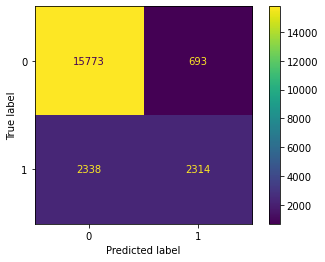

In [17]:
# confusion matrix for RF model
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [18]:
# Model evaluation for SVM model
y_pred = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, y_pred)
svm_recall = recall_score(y_test, y_pred)
svm_precision = precision_score(y_test, y_pred)
svm_f1score = f1_score(y_test, y_pred)
print(f'SVM model')
print(f'accuracy: {svm_accuracy}\nrecall: {svm_recall}\nprecision: {svm_precision}\nf1_score: {svm_f1score}')

SVM model
accuracy: 0.812955772326925
recall: 0.18873602751504728
precision: 0.8330170777988615
f1_score: 0.30774623203645285


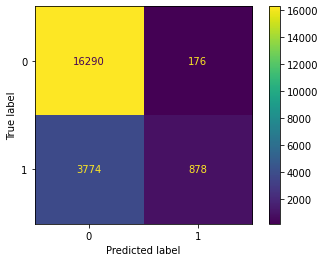

In [19]:
# confusion matrix for SVM model
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

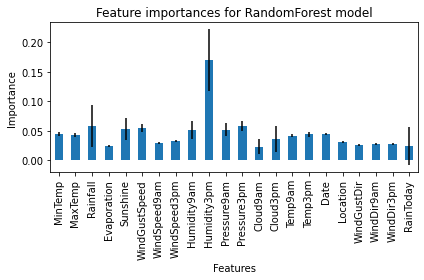

In [20]:
# RF feature importance
rf_feature_importance = rf_model.named_steps['classifier'].feature_importances_

features = numerical_features + categorical_features

forest_importances = pd.Series(rf_feature_importance, index=features)

std = np.std([tree.feature_importances_ for tree in rf_model.named_steps['classifier'].estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances for RandomForest model")
ax.set_ylabel("Importance")
ax.set_xlabel("Features")
fig.tight_layout()

In [21]:
# print feature importance for each feature in precentage for RF model
for feature, importance in zip(features, rf_feature_importance):
    print(f"{feature}: {round(100*importance,3)}%")

MinTemp: 4.408%
MaxTemp: 4.28%
Rainfall: 5.848%
Evaporation: 2.495%
Sunshine: 5.361%
WindGustSpeed: 5.453%
WindSpeed9am: 2.967%
WindSpeed3pm: 3.224%
Humidity9am: 5.183%
Humidity3pm: 17.02%
Pressure9am: 5.219%
Pressure3pm: 5.868%
Cloud9am: 2.321%
Cloud3pm: 3.614%
Temp9am: 4.191%
Temp3pm: 4.398%
Date: 4.488%
Location: 3.164%
WindGustDir: 2.636%
WindDir9am: 2.719%
WindDir3pm: 2.785%
RainToday: 2.359%


In [22]:
# SVM feature importance train set for SHAP
X_train_shap, unused_test, y_train_shap, unused_test_y = train_test_split(X_train, y_train, train_size=0.01, test_size=0.001)
X_train_shap.shape

(1126, 22)

In [23]:
unused_X, X_test_shap, unused_y, y_test_shap = train_test_split(X_test, y_test, test_size=0.004)
X_test_shap.shape

(85, 22)

In [24]:
# setup model for SHAP
# without pipeline to be able to use SHAP
# transform dataset before to be able to use SHAP
X_transformed_train_shap = pd.DataFrame(preprocessor.fit_transform(X_train_shap), columns=features)
X_transformed_test_shap = pd.DataFrame(preprocessor.fit_transform(X_test_shap), columns=features)
svm_model = SVC(probability=True)
svm_model.fit(X_transformed_train_shap, y_train_shap)

SVC(probability=True)

In [25]:
# use SHAP to calculate feature importances
# transform dataset before input to 
explainer = shap.Explainer(svm_model.predict_proba, X_transformed_train_shap)
shap_values = explainer(X_transformed_test_shap)

Permutation explainer: 86it [04:23,  3.14s/it]                                  


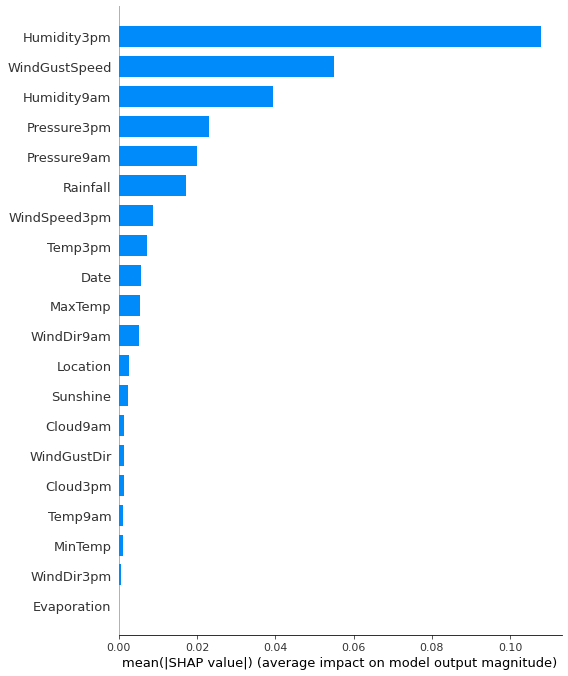

In [41]:
# Visualize the feature importance for both classes
shap.summary_plot(shap_values[:, :, 1], X_transformed_test_shap, plot_type="bar", title="Feature Importance - Rain in Austrailia", max_display=None)

In [38]:
# now drop Humidity3pm as it was the most important feature for both models
X_train_best_removed = X_train.drop(columns=['Humidity3pm'])
X_test_best_removed = X_test.drop(columns=['Humidity3pm'])
X_val_best_removed = X_val.drop(columns=['Humidity3pm'])
features_best_removed = features
features_best_removed.remove('Humidity3pm')

In [39]:
# set up column transformer
numerical_features_best_removed = numerical_features
numerical_features_best_removed.remove('Humidity3pm')
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numeric_transformer, numerical_features_best_removed),
        ('categorical', categorical_transformer, categorical_features)
    ])


In [41]:
# create a pipeline between preprocessor and ML models
rf_model = Pipeline(steps=[('transformed_data', preprocessor),
                      ('classifier', RandomForestClassifier())])
svm_model = Pipeline(steps=[('transformed_data', preprocessor),
                      ('classifier', SVC())])

In [42]:
# fit the models on the best feature removed dataset
rf_model.fit(X_train_best_removed, y_train)
svm_model.fit(X_train_best_removed, y_train)

Pipeline(steps=[('transformed_data',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['MinTemp', 'MaxTemp',
                                                   'Rainfall', 'Evaporation',
                                                   'Sunshine', 'WindGustSpeed',
                                                   'WindSpeed9am',
                                                   'WindSpeed3pm',
                                                   'Humidity9am', 'Pressure9am',
                                                   'Pressure3pm', 'Cloud9am',
                                                   'Cloud3pm', 'Temp9am',
                                                   'Temp3pm']),
                                                 ('categorical',
                                                  Pipeline(steps=[('categorical_transformer',
                                                                

In [43]:
# Model evaluation for RF model
y_pred = rf_model.predict(X_test_best_removed)
rf_accuracy = accuracy_score(y_test, y_pred)
rf_recall = recall_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred)
rf_f1score = f1_score(y_test, y_pred)
print(f'RF model')
print(f'accuracy: {rf_accuracy}\nrecall: {rf_recall}\nprecision: {rf_precision}\nf1_score: {rf_f1score}')

RF model
accuracy: 0.8514063831802254
recall: 0.4808638015822108
precision: 0.7600540723217303
f1_score: 0.5890518596123625


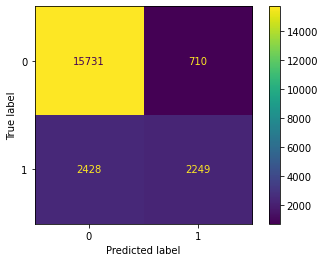

In [44]:
# confusion matrix for RF model
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [45]:
# Model evaluation for SVM model
y_pred = svm_model.predict(X_test_best_removed)
svm_accuracy = accuracy_score(y_test, y_pred)
svm_recall = recall_score(y_test, y_pred)
svm_precision = precision_score(y_test, y_pred)
svm_f1score = f1_score(y_test, y_pred)
print(f'SVM model')
print(f'accuracy: {svm_accuracy}\nrecall: {svm_recall}\nprecision: {svm_precision}\nf1_score: {svm_f1score}')

SVM model
accuracy: 0.7807084004167061
recall: 0.013256360915116528
precision: 0.7948717948717948
f1_score: 0.02607781282860147


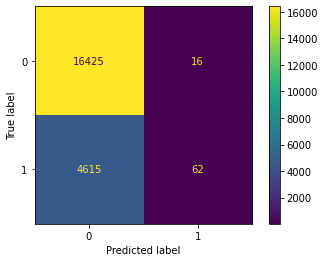

In [46]:
# confusion matrix for SVM model
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

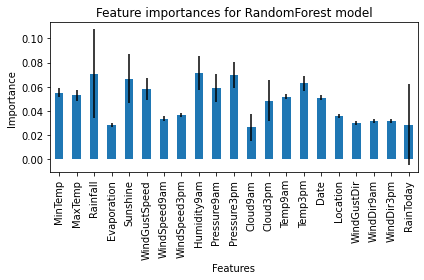

In [47]:
# RF feature importance best feature removed
rf_feature_importance = rf_model.named_steps['classifier'].feature_importances_

features = numerical_features + categorical_features

forest_importances = pd.Series(rf_feature_importance, index=features_best_removed)

std = np.std([tree.feature_importances_ for tree in rf_model.named_steps['classifier'].estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances for RandomForest model")
ax.set_ylabel("Importance")
ax.set_xlabel("Features")
fig.tight_layout()

In [48]:
# print feature importance for each feature in precentage for RF model
for feature, importance in zip(features_best_removed, rf_feature_importance):
    print(f"{feature}: {round(100*importance,3)}%")

MinTemp: 5.513%
MaxTemp: 5.291%
Rainfall: 7.083%
Evaporation: 2.83%
Sunshine: 6.659%
WindGustSpeed: 5.787%
WindSpeed9am: 3.377%
WindSpeed3pm: 3.643%
Humidity9am: 7.121%
Pressure9am: 5.899%
Pressure3pm: 6.968%
Cloud9am: 2.646%
Cloud3pm: 4.842%
Temp9am: 5.191%
Temp3pm: 6.28%
Date: 5.1%
Location: 3.574%
WindGustDir: 3.013%
WindDir9am: 3.159%
WindDir3pm: 3.161%
RainToday: 2.862%


In [49]:
# dataset for shap
X_transformed_train_shap_best_removed = X_transformed_train_shap.drop(columns=['Humidity3pm'])
X_transformed_test_shap_best_removed = X_transformed_test_shap.drop(columns=['Humidity3pm'])
svm_model = SVC(probability=True)
svm_model.fit(X_transformed_train_shap_best_removed, y_train_shap)

SVC(probability=True)

In [50]:
# use SHAP to calculate feature importances
# transform dataset before input to 
explainer_best_removed = shap.Explainer(svm_model.predict_proba, X_transformed_train_shap_best_removed)
shap_values_best_removed = explainer_best_removed(X_transformed_test_shap_best_removed)

Permutation explainer: 86it [04:09,  3.04s/it]                                  


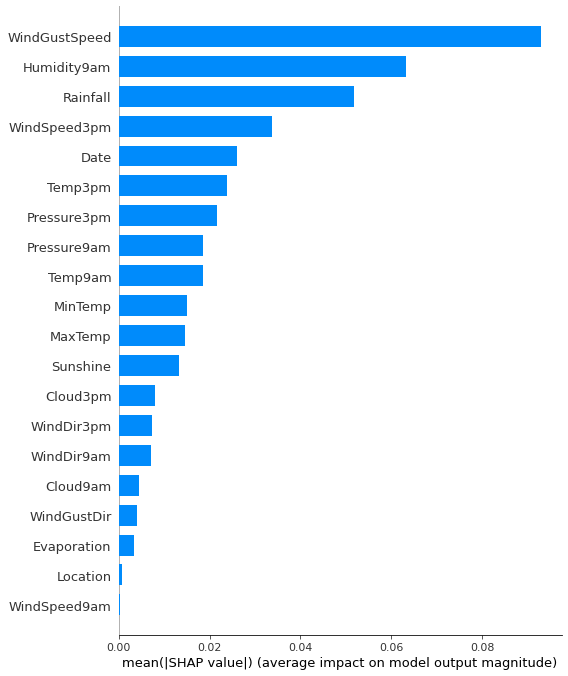

In [51]:
# Visualize the feature importance for both classes
shap.summary_plot(shap_values_best_removed[:, :, 1], X_transformed_test_shap_best_removed, plot_type="bar", title="Feature Importance - rain", max_display=None)